# Model Training w/ Patient List

In this notebook, we'll demonstrate how to generate CLMBR features given a list of patients and labels using a pre-trained CLMBR model, and train a simple classifier on top of a CLMBR-featurized dataset. The example dataset used here is a STARR OMOP dataset.

In [1]:
import torch

In [2]:
import os
import json
import ehr_ml.timeline
import ehr_ml.ontology
import ehr_ml.index
import ehr_ml.labeler
import ehr_ml.clmbr
import pandas as pd

from path_utils import load_extract_paths, update_extract_paths, load_dataset_paths, update_dataset_paths

MACHINE = 'nero'
DATASET = 'starr_omop_deid'
VERSION = '2021_12_13'
#paths = load_dataset_paths(MACHINE, DATASET, VERSION)
EHR_ML_EXTRACT_DIR = '/home/kbechler/dataset'
#paths.get('extract_dir', None)
CLMBR_INFO_DIR = "/invalid" 
#paths.get('info_dir', None)
MODEL_DIR = '/home/kbechler/model2'
#paths.get('model_dir', None)
#EXAMPLE_CSV = paths.get('example_csv', None)

# make any updates to the paths dictionary, and update the persistent config file with:
# update_dataset_paths(MACHINE, DATASET, VERSION, paths)

In [3]:
print(EHR_ML_EXTRACT_DIR)

/home/kbechler/dataset


In [4]:
print(MODEL_DIR)

/home/kbechler/model2


### Featurizing from a list of patients
In this use case, we assume that the user has prepared a list of patients, day offsets, and labels for use with training the model. Such a list can come from a query to BigQuery or similar service. We'll load in an example CSV file to demonstrate the minimum spec required.

In [5]:
os.getcwd()

'/home/kbechler/piton_private'

In [6]:
# Replace with SLE dataframe of patient list
dataframe = pd.read_csv('/home/kbechler/piton_private/df_clmbr_2022.csv')

In [7]:
dataframe.head()

,patient_id,date,label
0,32209409,2011-08-12,False
1,30924418,2011-09-27,False
2,31008811,2010-09-16,False
3,30742058,2011-11-29,False
4,32400899,2012-08-06,False


In [8]:
# Remove patients less than 14 years old
more_14 = pd.read_csv('/home/kbechler/piton_private/patient_df_less_14.csv')

In [9]:
patient_14 = list(more_14.subject_id)

In [10]:
dataframe = dataframe[dataframe.patient_id.isin(patient_14)]

In [11]:
sum(dataframe.label == False)

2608

In [12]:
sum(dataframe.label == True)

155

In [13]:
print(len(dataframe))

2763


In [14]:
# Remove held out test set
# Import held out test set to remove patients
heldout_test_set = pd.read_csv('/home/kbechler/test_set.csv')

In [18]:
test_patients = list(heldout_test_set.patient_id)

In [20]:
dataframe_train = dataframe[~dataframe.patient_id.isin(test_patients)]

In [21]:
print(len(dataframe_train))

2203


In [22]:
dataframe_test = dataframe[dataframe.patient_id.isin(test_patients)]

In [23]:
print(len(dataframe_test))

560


We note that if the data was the direct result of a BigQuery query, the patient IDs here don't exactly correspond to the patient IDs used by the `ehr_ml` Timeline object. Furthermore, we need to convert the date strings to date indices to index the last date we should use to featurize each patient. We'll do this preprocessing below using `ehr_ml.clmbr.convert_patient_data`.

In [24]:
ehr_ml_patient_ids, day_indices = ehr_ml.clmbr.convert_patient_data(EHR_ML_EXTRACT_DIR, 
                                                                    dataframe_train['patient_id'], dataframe_train['date'])

With the correct patient IDs and day indices in hand, we can now generate patient features using our pre-trained model. This is done in two steps:
1. Load in the pre-trained model with `ehr_ml.clmbr.CLMBRFeaturizer.from_pretrained`
2. Featurize with the `featurize_patients` method (**NOTE**: this method expects the _converted_ patient IDs and day indices as arguments!)

In [25]:
import numpy as np
ehr_ml_patient_ids = np.array(ehr_ml_patient_ids)
day_indices = np.array(day_indices)
labels = dataframe_train['label'].to_numpy()
clmbr_model = ehr_ml.clmbr.CLMBR.from_pretrained(MODEL_DIR)
features = clmbr_model.featurize_patients(EHR_ML_EXTRACT_DIR, ehr_ml_patient_ids, day_indices)

Computing patient representations: : 36it [00:01, 23.46it/s]                      

The tensors of interest for training our machine learning model are `features` and `labels`, which define our patient feature-matrix and our task-specific labels respectively.

In [26]:
features.shape, labels.shape

((2203, 800), (2203,))

### Training a logistic regression model
Next, we'll train a logistic regression model which can perform predictions based off our CLMBR representations. We'll first build a simple dataset out of our features and labels, and then define the model. We'll define a simple train / test split so we can measure the performance of our model.

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
# split patients into train / test cohorts, measure accuracy
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

BATCH_SIZE = 1024
EPOCHS = 100
EARLY_STOPPING_EPOCHS = 5
seed = 10

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.8, random_state = seed)

model = LogisticRegressionCV(Cs = 10**(np.linspace(-8,8,20)), scoring = "roc_auc").fit(X_train, y_train)

Computing patient representations: : 37it [00:01, 18.91it/s]
/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solv

/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kbechler/.conda/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [29]:
model.score(X_test, y_test)

0.8319592102408332

In [30]:
import sklearn

In [31]:
y_predict = model.predict_log_proba(X_test)

In [32]:
sklearn.metrics.roc_auc_score(y_test, y_predict[:,1])

0.8319592102408332

In [33]:
import matplotlib.pyplot as plt

In [34]:
from sklearn import metrics

In [35]:
results = {}

In [36]:
metric = ["accuracy", "balanced_accuracy", "roc_auc", "average_precision", "f1", "precision", "recall"]
def validation_results(clf, X_val, y_val, results):
    y_pred = clf.predict(X_val)
    y_score = clf.predict_proba(X_val)[:, 1]
    
    acc = metrics.accuracy_score(y_val, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_score)
    avg_prec = metrics.average_precision_score(y_val, y_score)
    f1 = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)     
    results['CLMBR'] = {"accuracy": acc,
                     "balanced_accuracy": bal_acc,
                     "roc_auc": roc_auc,
                     "average_precision": avg_prec,
                     "f1": f1,
                     "precision": precision,
                     "recall": recall}
    
    return results

In [37]:
# Plot roc pr curves
def plot_roc_pr_curves(X, y, clf, fig_size=(10, 8)):
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X, y, ax=ax)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic (ROC) Curve")
    plt.savefig('/home/kbechler/piton_private/plots/model_val_roc.png')
    plt.show()

    # PR Curve and AP (average precision)
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X, y, ax=ax)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall (PR) Curve")
    plt.savefig('/home/kbechler/piton_private/plots/model_val_pr.png')
    plt.show()


In [38]:
results = validation_results(model, X_test, y_test, results)

In [39]:
results

{'CLMBR': {'accuracy': 0.9478458049886621,
  'balanced_accuracy': 0.520340637882404,
  'roc_auc': 0.8319592102408332,
  'average_precision': 0.2991648684636044,
  'f1': 0.08,
  'precision': 0.3333333333333333,
  'recall': 0.045454545454545456}}

In [40]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['accuracy', 'balanced_accuracy', 
                                                                                   'roc_auc', 'average_precision', 
                                                                                   'f1', 'precision', 'recall'])

In [41]:
results_df.to_csv('/home/kbechler/piton_private/plots/results.csv')

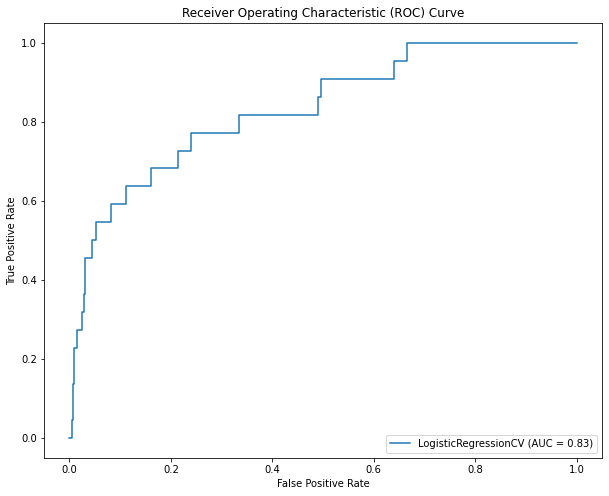

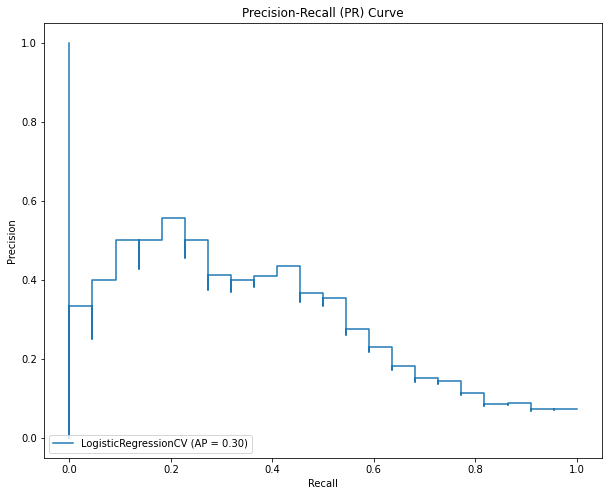

In [88]:
plot_roc_pr_curves(X_test, y_test, model)
#plt.savefig('/home/kbechler/piton_private/plots/model_val_auc.png')

### Using the trained model

Next we'll show how we can use our simple linear classifier to perform predictions on patients in new extracts. To do so, we need to provide a list of patient IDs and day offsets from a dataset extract to featurize them. For our purposes, we'll re-use a small list we got from our labeller, but you can imagine that these patient IDs can come from some other source (e.g. a query to BigQuery; in that case, we would have to perform our conversion to `ehr_ml`-friendly patient IDs and day indices again).

In [29]:
ehr_ml_patient_ids, day_indices = ehr_ml.clmbr.convert_patient_data(EHR_ML_EXTRACT_DIR, 
                                                                    dataframe_test['patient_id'], 
                                                                    dataframe_test['date'])

In [30]:
import numpy as np
ehr_ml_patient_ids = np.array(ehr_ml_patient_ids)
day_indices = np.array(day_indices)
labels = dataframe_test['label'].to_numpy()
clmbr_model = ehr_ml.clmbr.CLMBR.from_pretrained(MODEL_DIR)
features = clmbr_model.featurize_patients(EHR_ML_EXTRACT_DIR, ehr_ml_patient_ids, day_indices)

Computing patient representations: : 10it [00:00, 11.68it/s]                    

In [31]:
# SUBSET_SIZE = 1000

# pid_subset = ehr_ml_patient_ids[:SUBSET_SIZE]
# day_indices_subset = day_indices[:SUBSET_SIZE]

In [32]:
features.shape, labels.shape

((560, 800), (560,))

As before, we'll generate the features with `featurize_patients`. Note that while we use the same extract dir in this particular example, you will need to change out the extract dir to test on a different dataset.

In [33]:
# features = clmbr_model.featurize_patients(EHR_ML_EXTRACT_DIR, pid_subset, day_indices_subset)
# features.shape

In [34]:
predictions = model.predict(features)
#predictions

In [35]:
predictions_proba = model.predict_log_proba(features)

In [36]:
sklearn.metrics.roc_auc_score(labels, predictions_proba[:,1])

0.7984014720257605

Computing patient representations: : 11it [00:19, 11.68it/s]

In [94]:
def test_model(clf, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    # print out stats
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Model accuracy: %.3f\n" % accuracy)

    # precision, recall, and f1-score is usually reported for class 1 (in binary case)
    # recall of positive class (1) = sensitivity
    # recall of negative class (0) = specificity
    # precision of positive class (1) = PPV
    # precision of negative class (0) = NPV
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    cm_disp = metrics.plot_confusion_matrix(clf, X_test, y_test)  
    plt.savefig('/home/kbechler/piton_private/plots/model_test_cm.png')
    plt.show()

    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_test, y_pred_proba[:, 1])
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")
    plt.savefig('/home/kbechler/piton_private/plots/model_test_roc.png')
    plt.show()

    # PR Curve and AP (average precision)
    fig, ax_pr = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision-Recall (PR) Curve")
    plt.savefig('/home/kbechler/piton_private/plots/model_test_pr.png')
    plt.show()

In [53]:
features.shape

(560, 800)

In [54]:
labels.shape

(560,)

In [71]:
os.getcwd()

'/home/kbechler/piton_private'

Model accuracy: 0.943

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       527
        True       0.60      0.09      0.16        33

    accuracy                           0.94       560
   macro avg       0.77      0.54      0.56       560
weighted avg       0.93      0.94      0.92       560



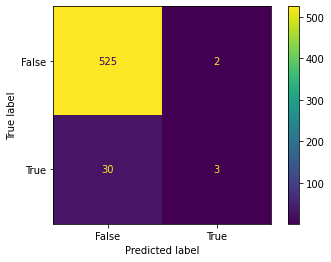

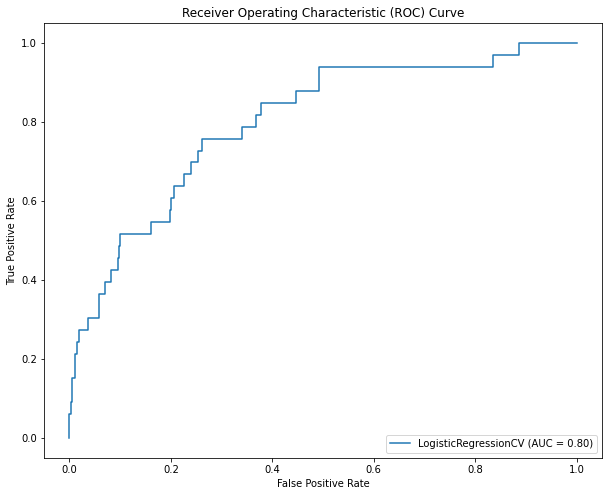

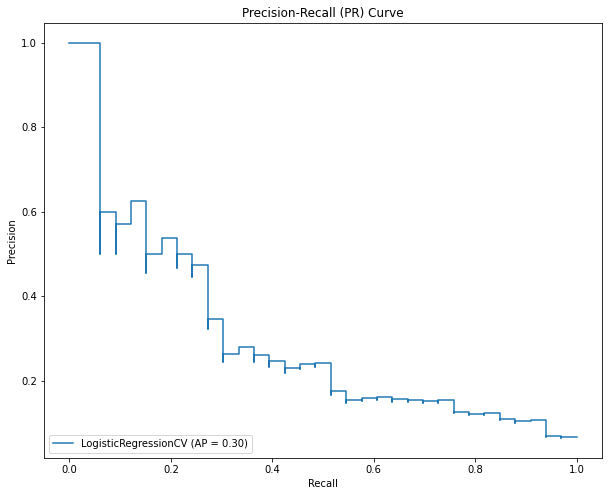

In [95]:
test_model(model, features, labels)

In [69]:
test_results = {}
test_results = validation_results(model, features, labels, test_results)

In [70]:
test_results

{'CLMBR': {'accuracy': 0.9428571428571428,
  'balanced_accuracy': 0.5435570122477144,
  'roc_auc': 0.7984014720257605,
  'average_precision': 0.3031600339487732,
  'f1': 0.15789473684210525,
  'precision': 0.6,
  'recall': 0.09090909090909091}}

In [76]:
test_results_df = pd.DataFrame.from_dict(test_results, orient = 'index', columns = ['accuracy', 'balanced_accuracy', 
                                                                                   'roc_auc', 'average_precision', 
                                                                                   'f1', 'precision', 'recall'])

In [78]:
test_results_df.to_csv('/home/kbechler/piton_private/plots/test_results.csv')

In [107]:
# Plot both validation and test roc on same plot

def plot_both(clf, X_val, y_val, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)


    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_val, y_pred_proba[:, 1])
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X_val, y_val, ax=ax_roc, name = "Internal Validation")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")
    
    y_pred_test = clf.predict(X_test)
    y_pred_proba_test = clf.predict_proba(X_test)


    auroc_test = metrics.roc_auc_score(y_test, y_pred_proba_test[:, 1])

    roc_disp = metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name = "Internal Evaluation on Held-Out Test Set")
    plt.savefig('/home/kbechler/piton_private/plots/test_val_roc.png')
    
    plt.show()

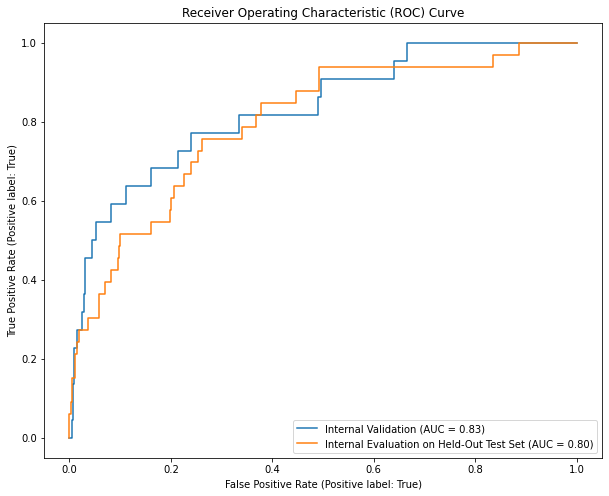

In [108]:
plot_both(model, X_test, y_test, features, labels)
